In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (12,4)

In [2]:
DATA_DIR = Path("data/raw/condition+monitoring+of+hydraulic+systems")

SENSORS_100HZ = ["PS1","PS2","PS3","PS4","PS5","PS6","EPS1"]
SENSORS_10HZ  = ["FS1","FS2"]
SENSORS_1HZ   = ["TS1","TS2","TS3","TS4","VS1"]

SENSORS = SENSORS_100HZ + SENSORS_10HZ + SENSORS_1HZ


In [3]:
def load_sensor_matrix(sensor_name):
    path = DATA_DIR / f"{sensor_name}.txt"
    return pd.read_csv(path, delim_whitespace=True, header=None)


In [4]:
sensor_data = {}

for sensor in SENSORS:
    sensor_data[sensor] = load_sensor_matrix(sensor)
    print(f"{sensor}: {sensor_data[sensor].shape}")


PS1: (2205, 6000)
PS2: (2205, 6000)
PS3: (2205, 6000)
PS4: (2205, 6000)
PS5: (2205, 6000)
PS6: (2205, 6000)
EPS1: (2205, 6000)
FS1: (2205, 600)
FS2: (2205, 600)
TS1: (2205, 60)
TS2: (2205, 60)
TS3: (2205, 60)
TS4: (2205, 60)
VS1: (2205, 60)


In [5]:
nbr_cycle = len(sensor_data["PS1"])
nbr_cycle

2205

Chaque ligne correspond à un cycle de production.
Chaque colonne correspond à un point temporel du capteur.

Les fréquences d’échantillonnage varient selon les capteurs.


In [6]:
def plot_sensor_cycles(sensor_name, cycles=sorted([random.randint(1, nbr_cycle) for _ in range(3)]), step=10):
    data = sensor_data[sensor_name]

    plt.figure(figsize=(10, 4))

    for c in cycles:
        plt.plot(
            data.iloc[c].values[::step],
            alpha=0.7,
            label=f"Cycle {c}"
        )

    plt.title(f"{sensor_name} – comparaison de cycles")
    plt.xlabel("Temps (échantillons)")
    plt.ylabel("Valeur du capteur")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()



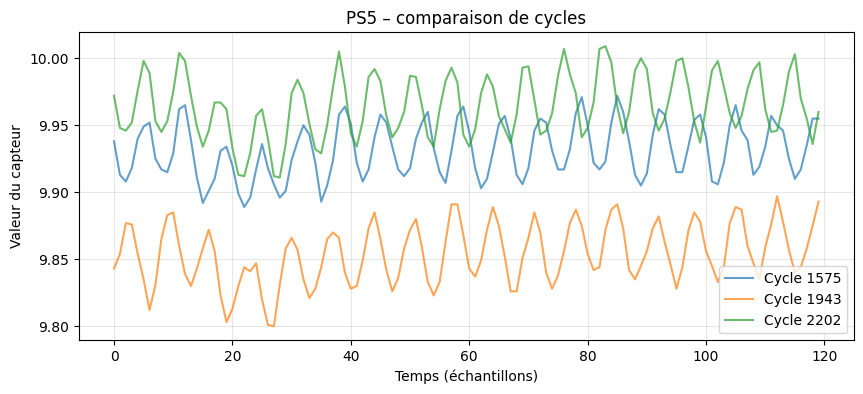

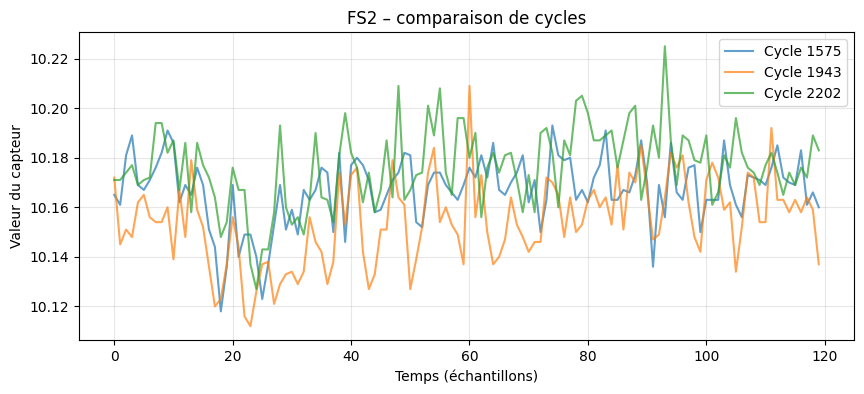

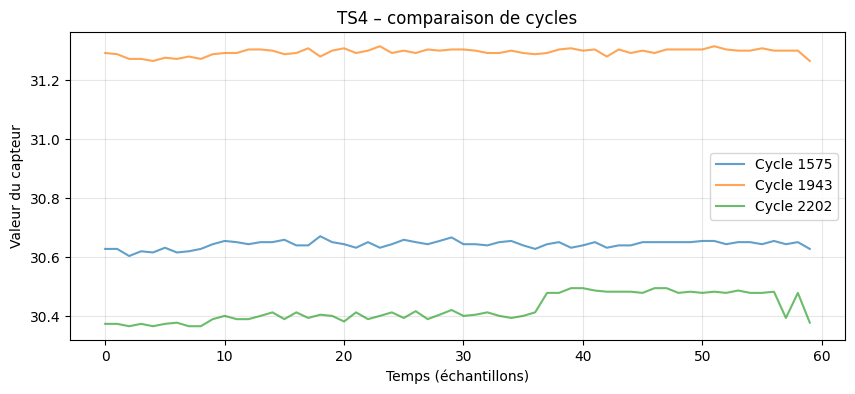

In [7]:
plot_sensor_cycles(random.choice(list(SENSORS_100HZ)), step=50)
plot_sensor_cycles(random.choice(list(SENSORS_10HZ)), step=5)
plot_sensor_cycles(random.choice(list(SENSORS_1HZ)), step=1)


Les capteurs PS1, FS1 et TS1 fournissent des informations complémentaires : la pression décrit les phases fonctionnelles, le débit capture les dynamiques critiques de la vanne, et la température reflète l’état thermique global du système. La conservation de la structure temporelle intra-cycle et un feature engineering adapté à la nature physique de chaque capteur sont essentiels pour une modélisation fiable de la condition de la valve

In [8]:
def plot_raw_vs_mean(sensor_name, cycles=None, step=10):
    if cycles is None:
        cycles = [random.randint(1, nbr_cycle - 1)]

    signal = sensor_data[sensor_name].iloc[cycles].values.flatten()

    plt.figure(figsize=(10, 4))
    plt.plot(signal[::step], label="Signal brut", alpha=0.8)
    plt.axhline(signal.mean(), color="red", linestyle="--", label="Moyenne")

    plt.title(f"{sensor_name} – signal brut vs moyenne")
    plt.xlabel("Temps (échantillons)")
    plt.ylabel("Valeur du capteur")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


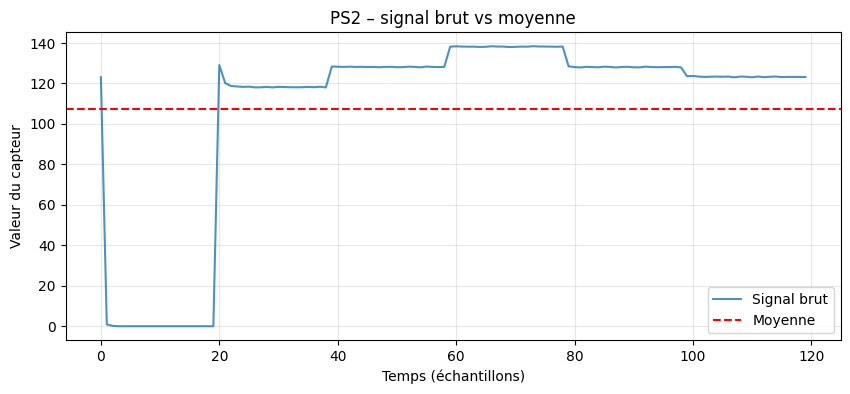

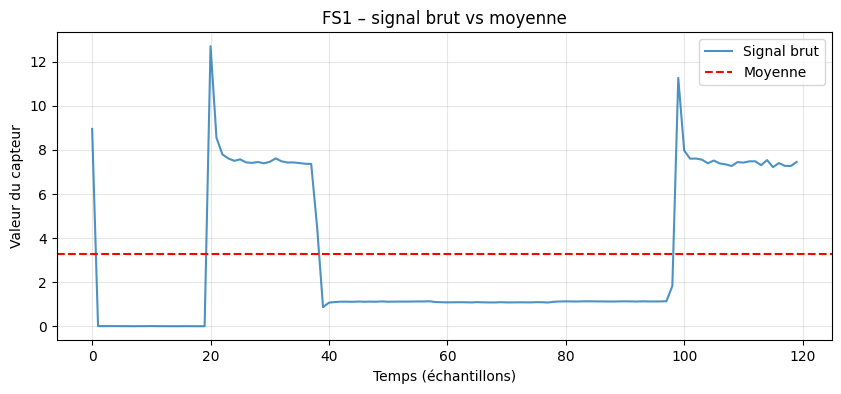

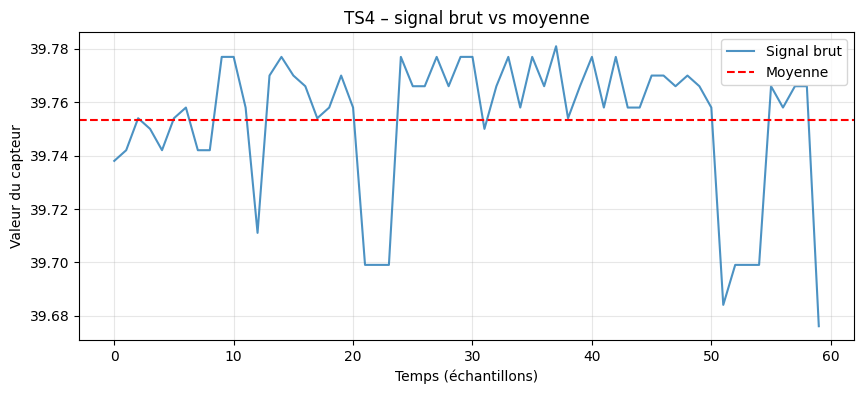

In [9]:
plot_raw_vs_mean(random.choice(list(SENSORS_100HZ)), step=50)
plot_raw_vs_mean(random.choice(list(SENSORS_10HZ)), step=5)
plot_raw_vs_mean(random.choice(list(SENSORS_1HZ)), step=1)


**Problèmes de l'approche "mean, std, min, max"**

Perte d'information temporelle critique

On perd l'ordre des événements
Les transitions (EPS1) ne sont pas capturées
La dynamique thermique (TS3) est écrasée


Pour la détection de défauts de vanne :

Une vanne défaillante peut avoir la même moyenne qu'une vanne saine
Mais des patterns temporels différents (retards, oscillations)
Les transitoires sont souvent plus informatifs que les moyennes


Perte de causalité

On ne vois pas : "La pression monte PUIS la température augmente"
On vois juste : "moyenne de pression" et "moyenne de température"**

Les signaux sont globalement stables à l’intérieur d’un cycle.
Les différences pertinentes apparaissent principalement entre cycles.

Les statistiques globales par cycle (moyenne, écart-type, min, max)
constituent une représentation adaptée pour la prédiction de l’état de la valve.


La prochaine étape consistera à extraire des features statistiques par capteur
et à construire un DataFrame final prêt pour l’apprentissage automatique.


In [11]:

print("SENSORS:", SENSORS)  # Vérifier qu'il y a des capteurs
print("Nombre de capteurs chargés:", len(sensor_data))


SENSORS: ['PS1', 'PS2', 'PS3', 'PS4', 'PS5', 'PS6', 'EPS1', 'FS1', 'FS2', 'TS1', 'TS2', 'TS3', 'TS4', 'VS1']
Nombre de capteurs chargés: 14
